In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings("ignore")

In [2]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Path setup
data_dir = "./BrainTumor/Brain Tumor/Brain Tumor"
csv_path = "./BrainTumor/Brain Tumor.csv"

# Load CSV
df = pd.read_csv(csv_path)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (3762, 15)


,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


In [4]:
df['Class'].value_counts()/len(df)*100


Class
0    55.263158
1    44.736842
Name: count, dtype: float64

<Axes: xlabel='Class'>

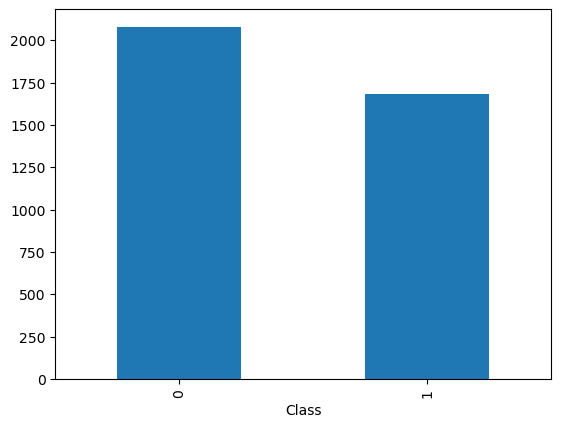

In [5]:
df['Class'].value_counts().plot(kind='bar')


findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.


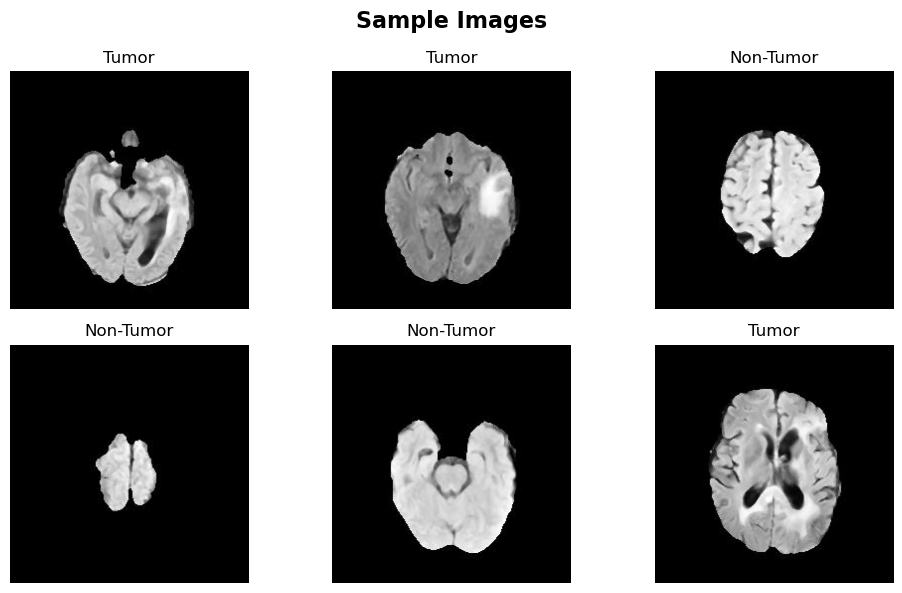

In [6]:
# Show some random images
plt.figure(figsize=(10,6))
for i in range(6):
    sample = df.sample(1).iloc[0]
    img_path = os.path.join(data_dir, sample['Image'] + '.jpg')
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title("Tumor" if sample['Class']==1 else "Non-Tumor")
    plt.axis("off")
plt.suptitle("Sample Images", fontsize=16, fontweight='bold', fontname='Tahoma')
plt.tight_layout()
plt.show()

In [7]:
img_path = os.path.join(data_dir, df['Image'].iloc[0]+'.jpg')
img = cv2.imread(img_path)
print("Image shape:", img.shape)
print("Total Images:", len(df))
print("Classes:", df['Class'].unique())

Image shape: (240, 240, 3)
Total Images: 3762
Classes: [0 1]


In [8]:
X = []
y = []

IMG_SIZE = 256

for i, row in df.iterrows():
    img_path = os.path.join(data_dir, row['Image']+'.jpg')
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X.append(img)
    y.append(row['Class'])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (3762, 256, 256, 3)
y shape: (3762,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("Training shape:", X_train.shape, "\nTesting shape:", X_test.shape)

Training shape: (2821, 256, 256, 3) 
Testing shape: (941, 256, 256, 3)


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation only for training
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.25
)


test_datagen = ImageDataGenerator(rescale=1./255)  # only rescale for test data

# Create generators
train_gen = train_datagen.flow(X_train, y_train, subset='training', batch_size=32, shuffle=True)
val_gen = train_datagen.flow(X_train, y_train, subset='validation', batch_size=32)
test_gen = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

In [11]:
model = Sequential([

    Conv2D(16, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(32, (5,5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (5,5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
 
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

I0000 00:00:1764256784.837926  248672 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 58, 58, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 520,961 (1.99 MB)

 Trainable params: 520,961 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
#               loss= tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction='none'),
#              metrics=[tf.metrics.Accuracy()])

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [14]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
 1/67 ━━━━━━━━━━━━━━━━━━━━ 9:04 8s/step - accuracy: 0.5625 - loss: 0.6888

I0000 00:00:1764256794.051841  248759 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 334ms/step - accuracy: 0.6985 - loss: 0.5829 - val_accuracy: 0.7404 - val_loss: 0.6013
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - accuracy: 0.7977 - loss: 0.4743 - val_accuracy: 0.7518 - val_loss: 0.5180
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 269ms/step - accuracy: 0.8313 - loss: 0.3973 - val_accuracy: 0.7163 - val_loss: 0.5711
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - accuracy: 0.8459 - loss: 0.3744 - val_accuracy: 0.8142 - val_loss: 0.4660
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 265ms/step - accuracy: 0.8478 - loss: 0.3537 - val_accuracy: 0.8369 - val_loss: 0.3908
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 265ms/step - accuracy: 0.8450 - loss: 0.3556 - val_accuracy: 0.8411 - val_loss: 0.3731
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - accuracy: 0.8492 - loss: 0.3650 - val_accuracy: 0.8199 - val_loss: 0.4074
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 263ms/step - accuracy: 0.8497 - loss: 0.3590 - val_accuracy

In [15]:
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc:.3f}")

y_pred = (model.predict(test_gen) > 0.5).astype("int32")

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9777 - loss: 0.0766
Test Accuracy: 0.978
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step  


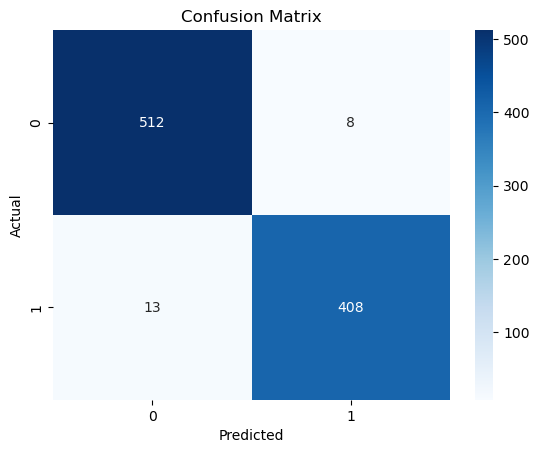

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       520
           1       0.98      0.97      0.97       421

    accuracy                           0.98       941
   macro avg       0.98      0.98      0.98       941
weighted avg       0.98      0.98      0.98       941



In [16]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_pred))

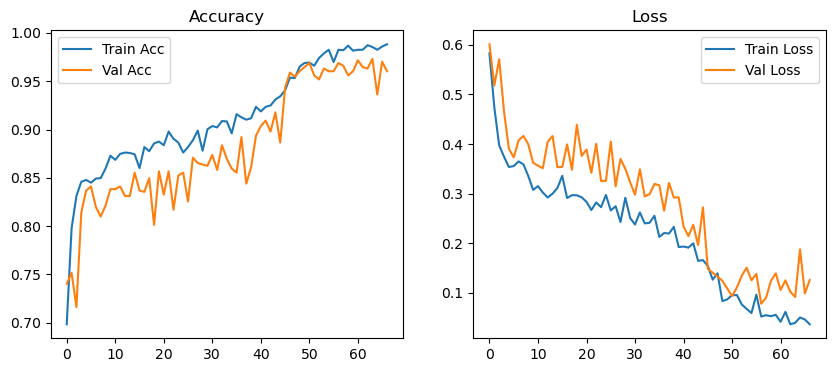

In [17]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.show()